# Classification de texte multiclasse avec PySpark

In [1]:
# Importer nos packages de machine learning
from pyspark import SparkContext

In [2]:
#Exécuter Spark localement avec 2 worker threads
sc = SparkContext(master="local[2]")

In [3]:
# Créer une session Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TextClassifierwithPySpark").getOrCreate()

In [4]:
# Charger notre Dataset
df = spark.read.csv(r'C:\Users\dell\Desktop\python\text_dataset.csv',header=True,inferSchema=True)

In [5]:
df.show()

+---+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|_c0|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration| published_timestamp|         subject|  clean_course_title|
+---+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|  0|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|           2147|         23|          51|        All Levels|       1.5 hours|2017-01-18T20:58:58Z|Business Finance|Ultimate Investme...|
|  1|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|           2792|        923|         274|        All Levels|        39 hours|2017-03-09T16:34:20Z

In [6]:
# afficher les colonnes 
df.columns

['_c0',
 'course_id',
 'course_title',
 'url',
 'is_paid',
 'price',
 'num_subscribers',
 'num_reviews',
 'num_lectures',
 'level',
 'content_duration',
 'published_timestamp',
 'subject',
 'clean_course_title']

In [7]:
#Sélectionner les colonnes nécessaires
df = df.select('course_title','subject')

In [8]:
df.show()

+--------------------+----------------+
|        course_title|         subject|
+--------------------+----------------+
|Ultimate Investme...|Business Finance|
|Complete GST Cour...|Business Finance|
|Financial Modelin...|Business Finance|
|Beginner to Pro -...|Business Finance|
|How To Maximize Y...|Business Finance|
|Trading Penny Sto...|Business Finance|
|Investing And Tra...|Business Finance|
|Trading Stock Cha...|Business Finance|
|Options Trading 3...|Business Finance|
|The Only Investme...|Business Finance|
|Forex Trading Sec...|Business Finance|
|Trading Options W...|Business Finance|
|Financial Managem...|Business Finance|
|Forex Trading Cou...|Business Finance|
|Python Algo Tradi...|Business Finance|
|Short Selling: Le...|Business Finance|
|Basic Technical A...|Business Finance|
|The Complete Char...|Business Finance|
|7 Deadly Mistakes...|Business Finance|
|Financial Stateme...|Business Finance|
+--------------------+----------------+
only showing top 20 rows



In [9]:
# Vérifier les valeurs manquantes
df.toPandas()['subject'].isnull().sum()

6

In [10]:
# Supprimer les valeurs manquantes
df = df.dropna(subset=('subject'))

In [11]:
# Vérifier la suppression des valeurs manquantes
df.toPandas()['subject'].isnull().sum()

0

In [12]:
# Compter par subject
df.groupBy('subject').count().show()

+--------------------+-----+
|             subject|count|
+--------------------+-----+
|play Electric Gui...|    1|
|Multiply returns ...|    1|
|    Business Finance| 1198|
|Introduction Guit...|    1|
|Learn Play Fernan...|    1|
|      Graphic Design|  603|
|Aprende tocar el ...|    1|
|     Web Development| 1200|
|Learn Classical G...|    1|
| Musical Instruments|  676|
+--------------------+-----+



In [13]:
# Nettoyer notre dataset
classes=["Web Development","Business Finance","Musical Instruments","Graphic Design"]
df = df.filter(df.subject.isin(classes))

In [14]:
# Recompter par subject
df.groupBy('subject').count().show()

+-------------------+-----+
|            subject|count|
+-------------------+-----+
|   Business Finance| 1198|
|     Graphic Design|  603|
|    Web Development| 1200|
|Musical Instruments|  676|
+-------------------+-----+



In [15]:
# charger le package 
import pyspark.ml.feature

In [16]:
#les méthodes disponibles
dir(pyspark.ml.feature)

['Binarizer',
 'BucketedRandomProjectionLSH',
 'BucketedRandomProjectionLSHModel',
 'Bucketizer',
 'ChiSqSelector',
 'ChiSqSelectorModel',
 'CountVectorizer',
 'CountVectorizerModel',
 'DCT',
 'ElementwiseProduct',
 'FeatureHasher',
 'HasAggregationDepth',
 'HasBlockSize',
 'HasCheckpointInterval',
 'HasCollectSubModels',
 'HasDistanceMeasure',
 'HasElasticNetParam',
 'HasFeaturesCol',
 'HasFitIntercept',
 'HasHandleInvalid',
 'HasInputCol',
 'HasInputCols',
 'HasLabelCol',
 'HasLoss',
 'HasMaxIter',
 'HasNumFeatures',
 'HasOutputCol',
 'HasOutputCols',
 'HasParallelism',
 'HasPredictionCol',
 'HasProbabilityCol',
 'HasRawPredictionCol',
 'HasRegParam',
 'HasRelativeError',
 'HasSeed',
 'HasSolver',
 'HasStandardization',
 'HasStepSize',
 'HasThreshold',
 'HasThresholds',
 'HasTol',
 'HasValidationIndicatorCol',
 'HasVarianceCol',
 'HasWeightCol',
 'HashingTF',
 'IDF',
 'IDFModel',
 'Imputer',
 'ImputerModel',
 'IndexToString',
 'Interaction',
 'JavaEstimator',
 'JavaMLReadable',
 'Jav

In [17]:
# Importer les packages requis pour initialiser les étapes du pipeline
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF
from pyspark.ml.feature import StringIndexer

In [18]:
# Stages pour le Pipeline
tokenizer = Tokenizer(inputCol='course_title',outputCol='mytokens')
stopwords_remover = StopWordsRemover(inputCol='mytokens',outputCol='filtered_tokens')
vectorizer = CountVectorizer(inputCol='filtered_tokens',outputCol='rawFeatures')
idf = IDF(inputCol='rawFeatures',outputCol='vectorizedFeatures')

In [19]:
#L'encoding du label/L'indexing du label
labelEncoder = StringIndexer(inputCol='subject',outputCol='label').fit(df)

In [20]:
labelEncoder.transform(df).show(5)

+--------------------+----------------+-----+
|        course_title|         subject|label|
+--------------------+----------------+-----+
|Ultimate Investme...|Business Finance|  1.0|
|Complete GST Cour...|Business Finance|  1.0|
|Financial Modelin...|Business Finance|  1.0|
|Beginner to Pro -...|Business Finance|  1.0|
|How To Maximize Y...|Business Finance|  1.0|
+--------------------+----------------+-----+
only showing top 5 rows



In [21]:
labelEncoder.labels

['Web Development',
 'Business Finance',
 'Musical Instruments',
 'Graphic Design']

In [22]:
# attribuer des valeurs numériques aux catégories pour des prédictions faciles.
label_dict = {'Web Development':0.0,
 'Business Finance':1.0,
 'Musical Instruments':2.0,
 'Graphic Design':3.0}

In [23]:
#ajouter les étiquettes aux catégories de sujets respectives
df = labelEncoder.transform(df)

In [24]:
df.show(5)

+--------------------+----------------+-----+
|        course_title|         subject|label|
+--------------------+----------------+-----+
|Ultimate Investme...|Business Finance|  1.0|
|Complete GST Cour...|Business Finance|  1.0|
|Financial Modelin...|Business Finance|  1.0|
|Beginner to Pro -...|Business Finance|  1.0|
|How To Maximize Y...|Business Finance|  1.0|
+--------------------+----------------+-----+
only showing top 5 rows



In [25]:
#Diviser notre dataset
#70 % pour le training et 30 % pour le testing.
(trainDF,testDF) = df.randomSplit((0.7,0.3),seed=42)

In [26]:
trainDF.show()

+--------------------+-------------------+-----+
|        course_title|            subject|label|
+--------------------+-------------------+-----+
|#1 Piano Hand Coo...|Musical Instruments|  2.0|
|#10 Hand Coordina...|Musical Instruments|  2.0|
|#4 Piano Hand Coo...|Musical Instruments|  2.0|
|#5  Piano Hand Co...|Musical Instruments|  2.0|
|#6 Piano Hand Coo...|Musical Instruments|  2.0|
|'Geometry Of Chan...|   Business Finance|  1.0|
|1 - Concepts of S...|   Business Finance|  1.0|
|          1 Hour CSS|    Web Development|  0.0|
|         1 Hour HTML|    Web Development|  0.0|
|10 Numbers Every ...|   Business Finance|  1.0|
|10.  Bonds and Bo...|   Business Finance|  1.0|
|101 Awesome Rocka...|Musical Instruments|  2.0|
|15  Motion Graphi...|     Graphic Design|  3.0|
|150 Rock Guitar L...|Musical Instruments|  2.0|
|188% Profit in 1Y...|   Business Finance|  1.0|
|2 Easy Steps To I...|   Business Finance|  1.0|
|2. Principles of ...|   Business Finance|  1.0|
|3. Compound Inter..

In [27]:
#importer l'algorithme de la regression logistique
from pyspark.ml.classification import LogisticRegression

In [28]:
#Création d'un estimateur
lr = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='label')

In [29]:
#Construire le pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf,lr])

In [30]:
# Création du Modèl
lr_model = pipeline.fit(trainDF)

In [31]:
# tester le Modèle
predictions = lr_model.transform(testDF)

In [32]:
predictions.show()

+--------------------+-------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        course_title|            subject|label|            mytokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|       rawPrediction|         probability|prediction|
+--------------------+-------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|#12 Hand Coordina...|Musical Instruments|  2.0|[#12, hand, coord...|[#12, hand, coord...|(3677,[341,486,59...|(3677,[341,486,59...|[2.22569868792268...|[0.05906161979394...|       2.0|
|#7 Piano Hand Coo...|Musical Instruments|  2.0|[#7, piano, hand,...|[#7, piano, hand,...|(3677,[11,14,67,3...|(3677,[11,14,67,3...|[-3.5764819917411...|[1.90320731747435...|       2.0|
|'Greensleeves' Cr...|Musical Instruments|  2.0|['greensleeves', ...|[

In [33]:
# sélectionnons les colonnes du prédictions
predictions.columns

['course_title',
 'subject',
 'label',
 'mytokens',
 'filtered_tokens',
 'rawFeatures',
 'vectorizedFeatures',
 'rawPrediction',
 'probability',
 'prediction']

In [34]:
#sélectionnons les colonnes nécessaires utilisées pour les prédictions
predictions.select('rawPrediction','probability','subject','label','prediction').show(10)

+--------------------+--------------------+-------------------+-----+----------+
|       rawPrediction|         probability|            subject|label|prediction|
+--------------------+--------------------+-------------------+-----+----------+
|[2.22569868792268...|[0.05906161979394...|Musical Instruments|  2.0|       2.0|
|[-3.5764819917411...|[1.90320731747435...|Musical Instruments|  2.0|       2.0|
|[-4.0775594764909...|[8.81118803746647...|Musical Instruments|  2.0|       2.0|
|[-5.4931926196219...|[6.15704952459071...|   Business Finance|  1.0|       1.0|
|[14.5287723863393...|[0.99999996613121...|    Web Development|  0.0|       0.0|
|[12.4929016728500...|[0.99999947737616...|    Web Development|  0.0|       0.0|
|[-3.3864292131655...|[3.61573413005749...|   Business Finance|  1.0|       1.0|
|[-3.5521799441034...|[3.8678011685528E...|Musical Instruments|  2.0|       2.0|
|[-4.7469948054573...|[6.14302989842377...|   Business Finance|  1.0|       1.0|
|[-13.271809535011...|[1.441

In [35]:
# Evaluation du  Modèl 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')

In [36]:
#obtenir la précision
accuracy = evaluator.evaluate(predictions)

In [37]:
accuracy = evaluator.evaluate(predictions)

In [38]:
accuracy

0.9218303145853194

In [39]:
y_true = predictions.select('label')
y_true = y_true.toPandas()
y_pred = predictions.select('prediction')
y_pred = y_pred.toPandas()

In [40]:
from sklearn.metrics import confusion_matrix,classification_report

In [41]:
cm = confusion_matrix(y_true,y_pred)

In [42]:
cm

array([[333,   3,   0,   8],
       [ 30, 319,   2,   2],
       [  6,   3, 174,   0],
       [ 15,   7,   6, 141]], dtype=int64)

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,title='Matrice de confusion\n\n',cmap=plt.cm.Blues):

    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
label_dict.keys()

dict_keys(['Web Development', 'Business Finance', 'Musical Instruments', 'Graphic Design'])

In [45]:
class_names = ['Web Development', 'Business Finance', 'Musical Instruments', 'Graphic Design']

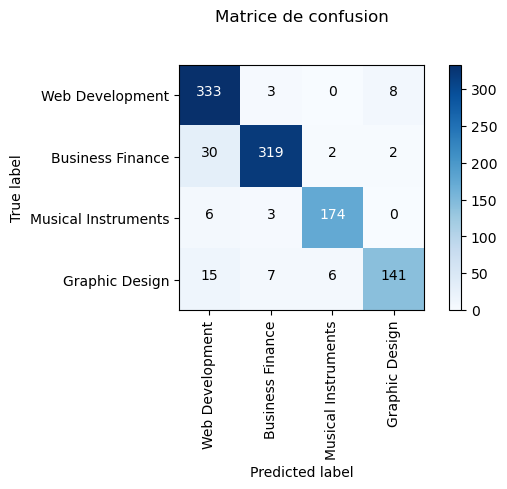

In [46]:
plot_confusion_matrix(cm,class_names)

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Classication Report
print(classification_report(y_true,y_pred,target_names=class_names))

                     precision    recall  f1-score   support

    Web Development       0.87      0.97      0.91       344
   Business Finance       0.96      0.90      0.93       353
Musical Instruments       0.96      0.95      0.95       183
     Graphic Design       0.93      0.83      0.88       169

           accuracy                           0.92      1049
          macro avg       0.93      0.91      0.92      1049
       weighted avg       0.92      0.92      0.92      1049



In [54]:
#préparer notre échantillon d'entrée sous forme de chaîne.
from pyspark.sql.types import StringType
ex1 = spark.createDataFrame([("how to create a web application with Laravel framework",StringType())],
# Nom du colonne
["course_title"]
)

In [55]:
ex1.show(truncate=False)

+------------------------------------------------------+---+
|course_title                                          |_2 |
+------------------------------------------------------+---+
|how to create a web application with Laravel framework|[] |
+------------------------------------------------------+---+



In [56]:
# faire une prédiction
pred_ex1 = lr_model.transform(ex1)
pred_ex1.select('course_title','rawPrediction','probability','prediction').show()

+--------------------+--------------------+--------------------+----------+
|        course_title|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|how to create a w...|[21.7020474007322...|[0.99999999999851...|       0.0|
+--------------------+--------------------+--------------------+----------+



In [57]:
label_dict

{'Web Development': 0.0,
 'Business Finance': 1.0,
 'Musical Instruments': 2.0,
 'Graphic Design': 3.0}